In [45]:
import import_ipynb
import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap

- remove seasonablity
- drop nans (if pre-processing from seasonality)
- others?
- try to understand autocorrelation in initial features
- 

- get residuals for each timestep
- cluster the residuals
- adaptive thresholding (exponential moving average could be good)
- use windowing to be more robust to what average values should be. 
- feature engineering -> add month, add important interaction terms, 

- rule based detection (set threshold based on training data)
- require multiple anomalies in a row to happen in order to flag is an anomaly. 

In [46]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [47]:
# # training data
# u4_train_equil_turbine = josh_data_preprocessing.u4_train_equil_turbine
# u4_train_equil_pump = josh_data_preprocessing.u4_train_equil_pump
# u5_train_equil_turbine = josh_data_preprocessing.u5_train_equil_turbine
# u5_train_equil_pump = josh_data_preprocessing.u5_train_equil_pump
# u6_train_equil_turbine = josh_data_preprocessing.u6_train_equil_turbine
# u6_train_equil_pump = josh_data_preprocessing.u6_train_equil_pump

# # synethetic test sets
# u5_s01_equil_turbine = josh_data_preprocessing.u5_s01_equil_turbine
# u5_s01_equil_pump = josh_data_preprocessing.u5_s01_equil_pump
# u5_s02_equil_turbine = josh_data_preprocessing.u5_s02_equil_turbine
# u5_s02_equil_pump = josh_data_preprocessing.u5_s02_equil_pump
# u6_s01_equil_turbine = josh_data_preprocessing.u6_s01_equil_turbine
# u6_s01_equil_pump = josh_data_preprocessing.u6_s01_equil_pump
# u6_s02_equil_turbine = josh_data_preprocessing.u6_s02_equil_turbine
# u6_s02_equil_pump = josh_data_preprocessing.u6_s02_equil_pump

# # real test sets
# u4_test_equil_turbine = josh_data_preprocessing.u4_test_equil_turbine
# u4_test_equil_pump = josh_data_preprocessing.u4_test_equil_pump
# u5_test_equil_turbine = josh_data_preprocessing.u5_test_equil_turbine
# u5_test_equil_pump = josh_data_preprocessing.u5_test_equil_pump
# u6_test_equil_turbine = josh_data_preprocessing.u6_test_equil_turbine
# u6_test_equil_pump = josh_data_preprocessing.u6_test_equil_pump

In [48]:
# # need to add _ema_10 to all the features!

# features = [
#     'tot_activepower', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening',
#     'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow',
#     'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed',
#     'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'timer_turbine_on_off'
#     'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'is_weekend', 
# ]

In [49]:
train_dataset = u5_train_equil_pump
test_dataset = u5_s01_equil_pump

In [50]:
features = ['tot_activepower', 'ext_tmp', 'plant_tmp', 'coupler_position', 'pump_calculated_flow', 
            'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed', 
            'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'turbine_cycle_id', 
            'pump_cycle_id', 'scaled_injector_sum', 'minute', 'hour', 'day', 'month', 'year', 
            'dayofweek', 'dayofyear', 
            # 'tot_activepower_lag_1', 'tot_activepower_lag_3', 
            # 'tot_activepower_lag_10', 'ext_tmp_lag_1', 'ext_tmp_lag_3', 'ext_tmp_lag_10', 
            # 'plant_tmp_lag_1', 'plant_tmp_lag_3', 'plant_tmp_lag_10', 'coupler_position_lag_1', 
            # 'coupler_position_lag_3', 'coupler_position_lag_10', 'pump_calculated_flow_lag_1', 
            # 'pump_calculated_flow_lag_3', 'pump_calculated_flow_lag_10', 'pump_pressure_diff_lag_1', 
            # 'pump_rotspeed_lag_1', 'pump_rotspeed_lag_3', 'pump_rotspeed_lag_10', 'turbine_pressure_lag_1', 
            # 'turbine_pressure_lag_3', 'turbine_pressure_lag_10', 'turbine_rotspeed_lag_1', 
            # 'turbine_rotspeed_lag_3', 'turbine_rotspeed_lag_10', 'water_primary_pump_01_opening_lag_1', 
            # 'water_primary_pump_01_opening_lag_3', 'water_primary_pump_01_opening_lag_10', 
            # 'water_primary_pump_02_opening_lag_1', 'water_primary_pump_02_opening_lag_3', 
            # 'water_primary_pump_02_opening_lag_10', 'turbine_cycle_id_lag_1', 'turbine_cycle_id_lag_3', 
            # 'turbine_cycle_id_lag_10', 'pump_cycle_id_lag_1', 'pump_cycle_id_lag_3', 'pump_cycle_id_lag_10'
        ]


In [51]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in train_dataset.columns]

target_features = ['charge', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'air_circ_cold_01_tmp', 
    'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 
    'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 
    'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 
    'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 
    'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 
    'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp', 'stat_coil_ph01_04_tmp', 
    'stat_coil_ph01_05_tmp', 'stat_coil_ph01_06_tmp', 'stat_coil_ph02_01_tmp', 'stat_coil_ph02_02_tmp', 
    'stat_coil_ph02_03_tmp', 'stat_coil_ph02_04_tmp', 'stat_coil_ph02_05_tmp', 'stat_coil_ph02_06_tmp', 
    'stat_coil_ph03_01_tmp', 'stat_coil_ph03_02_tmp', 'stat_coil_ph03_03_tmp', 'stat_coil_ph03_04_tmp', 
    'stat_coil_ph03_05_tmp', 'stat_coil_ph03_06_tmp', 'stat_magn_01_tmp', 'stat_magn_02_tmp', 
    'stat_magn_03_tmp', 'stat_magn_04_tmp', 'stat_magn_05_tmp', 'stat_magn_06_tmp', 'stat_magn_07_tmp', 
    'stat_magn_08_tmp', 'stat_magn_09_tmp', 'stat_magn_10_tmp', 'stat_magn_11_tmp', 'stat_magn_12_tmp', 
    'water_circ_cold_tmp', 'water_circ_flow', 'water_circ_hot_01_tmp', 'water_circ_hot_02_tmp', 
    'water_circ_hot_03_tmp', 'water_circ_hot_04_tmp', 'water_circ_hot_05_tmp', 'water_circ_hot_06_tmp', 
    'water_circ_hot_tmp', 'air_gap_negative_x_position', 'air_gap_positive_x_position', 
    'air_gap_negative_y_position', 'air_gap_positive_y_position'
    ]

# Split the data into training and testing sets
train = train_dataset[features]
y = train_dataset[target_features]

In [52]:
# # Standardize the features before applying PCA
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Applying PCA
# pca = PCA(n_components=0.95)  # Keep 95% of variance
# X_pca = pca.fit_transform(X_scaled)

# print(f"Reduced number of features from {X.shape[1]} to {X_pca.shape[1]}")

In [53]:
# import optuna
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the objective function for Optuna
# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameters to tune
#     # n_estimators = trial.suggest_int('n_estimators', 10, 100)
#     n_estimators = 10
#     max_depth = trial.suggest_int('max_depth', 3, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # 'auto' removed

#     # Create the RandomForestRegressor with the suggested hyperparameters
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # Train the model
#     model.fit(X_train, y_train)

#     # Predict on the validation set
#     y_val_pred = model.predict(X_val)

#     # Calculate RMSE as the evaluation metric
#     rmse = mean_squared_error(y_val, y_val_pred, squared=False)
#     return rmse


# # Create an Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # Number of trials

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

# # Train the final model with the best hyperparameters
# best_params = study.best_params

In [54]:
final_model = RandomForestRegressor(
    n_estimators=5,
    # n_estimators=best_params['n_estimators'],
    # max_depth=best_params['max_depth'],
    # min_samples_split=best_params['min_samples_split'],
    # min_samples_leaf=best_params['min_samples_leaf'],
    # max_features=best_params['max_features'],
    random_state=42
)

final_model.fit(train, y)

# Predict on the test set
y_pred = final_model.predict(train)

residuals = y - y_pred

# Compute the residual norm for each timestamp in the training data
residuals_norm = np.linalg.norm(residuals, axis=1)

# Define your threshold. For example, using mean + 4 * std:
mean_norm = np.mean(residuals_norm)
std_norm = np.std(residuals_norm)
threshold = mean_norm + 4 * std_norm

In [55]:
# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r_squared = r2_score(y_test, y_pred)


# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f"R squared : {r_squared}")

In [56]:
# plt.figure(figsize=(12, 6))
# sns.histplot(u5_s01_equil_pump["anomaly"], kde=False, color='blue', bins=2)
# plt.title('Distribution of anomalies')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.show()

In [57]:
# plt.figure(figsize=(12, 6))
# sns.histplot(residuals, kde=True, color='blue', bins=30)
# plt.title('Distribution of Residuals')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.show()

In [58]:
# # Basic statistical measures
# mean_residual = np.mean(residuals)
# std_residual = np.std(residuals)
# max_residual = np.max(residuals)
# min_residual = np.min(residuals)

# print(f"Mean of Residuals: {mean_residual}")
# print(f"Standard Deviation of Residuals: {std_residual}")
# print(f"Max Residual: {max_residual}")
# print(f"Min Residual: {min_residual}")


# # Example threshold at 3 standard deviations from the mean
# threshold = mean_residual + 4 * std_residual
# print(f"Anomaly Threshold: {threshold}")

In [59]:
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
# plt.show()

# # Plot the actual and predicted values over the test set
# plt.figure(figsize=(14, 7))
# plt.scatter(y_test.index, y_test)
# plt.scatter(y_test.index, y_pred)
# # plt.plot(y_test.index, y_test, label='Actual Values', color='blue', marker='o')
# # plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
# plt.title('Comparison of Actual and Predicted Values')
# plt.xlabel('Index')
# plt.ylabel('Stator Coil Temperature')
# plt.legend()
# plt.show()

# Test

In [60]:
# For the synthetic test set:
X_synthetic = test_dataset[features]
y_synthetic = test_dataset[target_features]  # target is now multi-dimensional
y_pred_synthetic = final_model.predict(X_synthetic)
residuals_synthetic = y_pred_synthetic - y_synthetic  # shape: (n_samples, n_target_features)

# Compute the norm of the synthetic test residuals
residuals_synthetic_norm = np.linalg.norm(residuals_synthetic, axis=1)

# Classify anomalies based on the threshold
predicted_anomalies = (residuals_synthetic_norm > threshold).astype(int)

# For evaluation:
true_anomalies = test_dataset['anomaly']

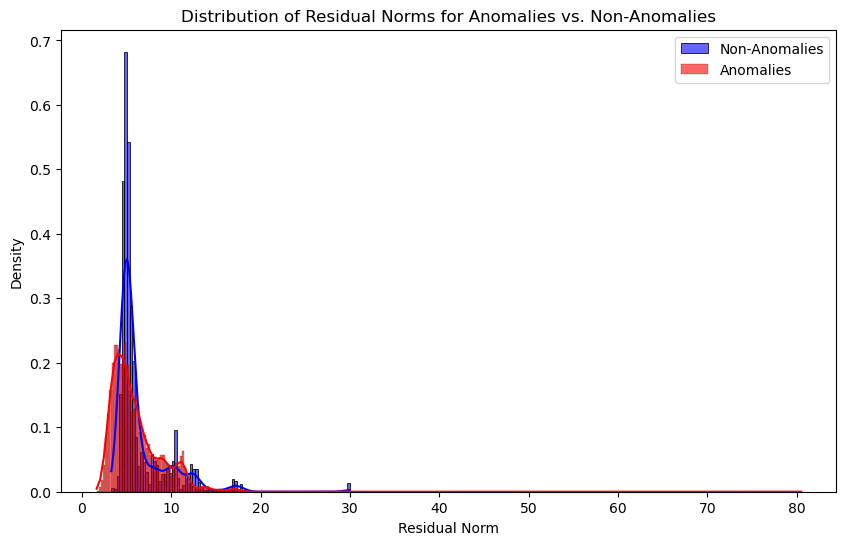

In [61]:
# If you want to plot the distribution:
anomalies = residuals_synthetic_norm[true_anomalies == 1]
non_anomalies = residuals_synthetic_norm[true_anomalies == 0]

plt.figure(figsize=(10, 6))
sns.histplot(non_anomalies, kde=True, color='blue', label='Non-Anomalies', stat='density', alpha=0.6)
sns.histplot(anomalies, kde=True, color='red', label='Anomalies', stat='density', alpha=0.6)

plt.xlabel('Residual Norm')
plt.ylabel('Density')
plt.title('Distribution of Residual Norms for Anomalies vs. Non-Anomalies')
plt.legend()
plt.show()

In [62]:
# # Extracting the features and target from the synthetic test set
# X_synthetic = test_dataset[features]

# y_synthetic = test_dataset[target_features]

# # Predict using the trained model
# y_pred_synthetic = final_model.predict(X_synthetic)

# residuals_synthetic = y_pred_synthetic - y_synthetic

# # Classify based on threshold
# residuals_abs = np.abs(residuals_synthetic)

# # predicted_anomalies = (abs(residuals_synthetic) > threshold).astype(int)

# # # Evaluate the model
# # true_anomalies = test_dataset['anomaly']

In [63]:
# # Evaluate the model performance on synthetic data
# mse_synthetic = mean_squared_error(y_synthetic, y_pred_synthetic)
# rmse_synthetic = np.sqrt(mse_synthetic)
# r_squared_synthetic = r2_score(y_synthetic, y_pred_synthetic)

# print(f'Mean Squared Error on Synthetic Data: {mse_synthetic}')
# print(f'Root Mean Squared Error on Synthetic Data: {rmse_synthetic}')
# print(f"R squared : {r_squared_synthetic}")

In [64]:
# # Visualizing the results with a scatter plot for actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(y_synthetic.index, y_synthetic, label='Actual Values (Synthetic)', color='blue')
# plt.scatter(y_synthetic.index, y_pred_synthetic, label='Predicted Values (Synthetic)', color='red')
# plt.title('Comparison of Actual and Predicted Values on Synthetic Data')
# plt.xlabel('Index')
# plt.ylabel('Stator Coil Temperature')
# plt.legend()
# plt.show()

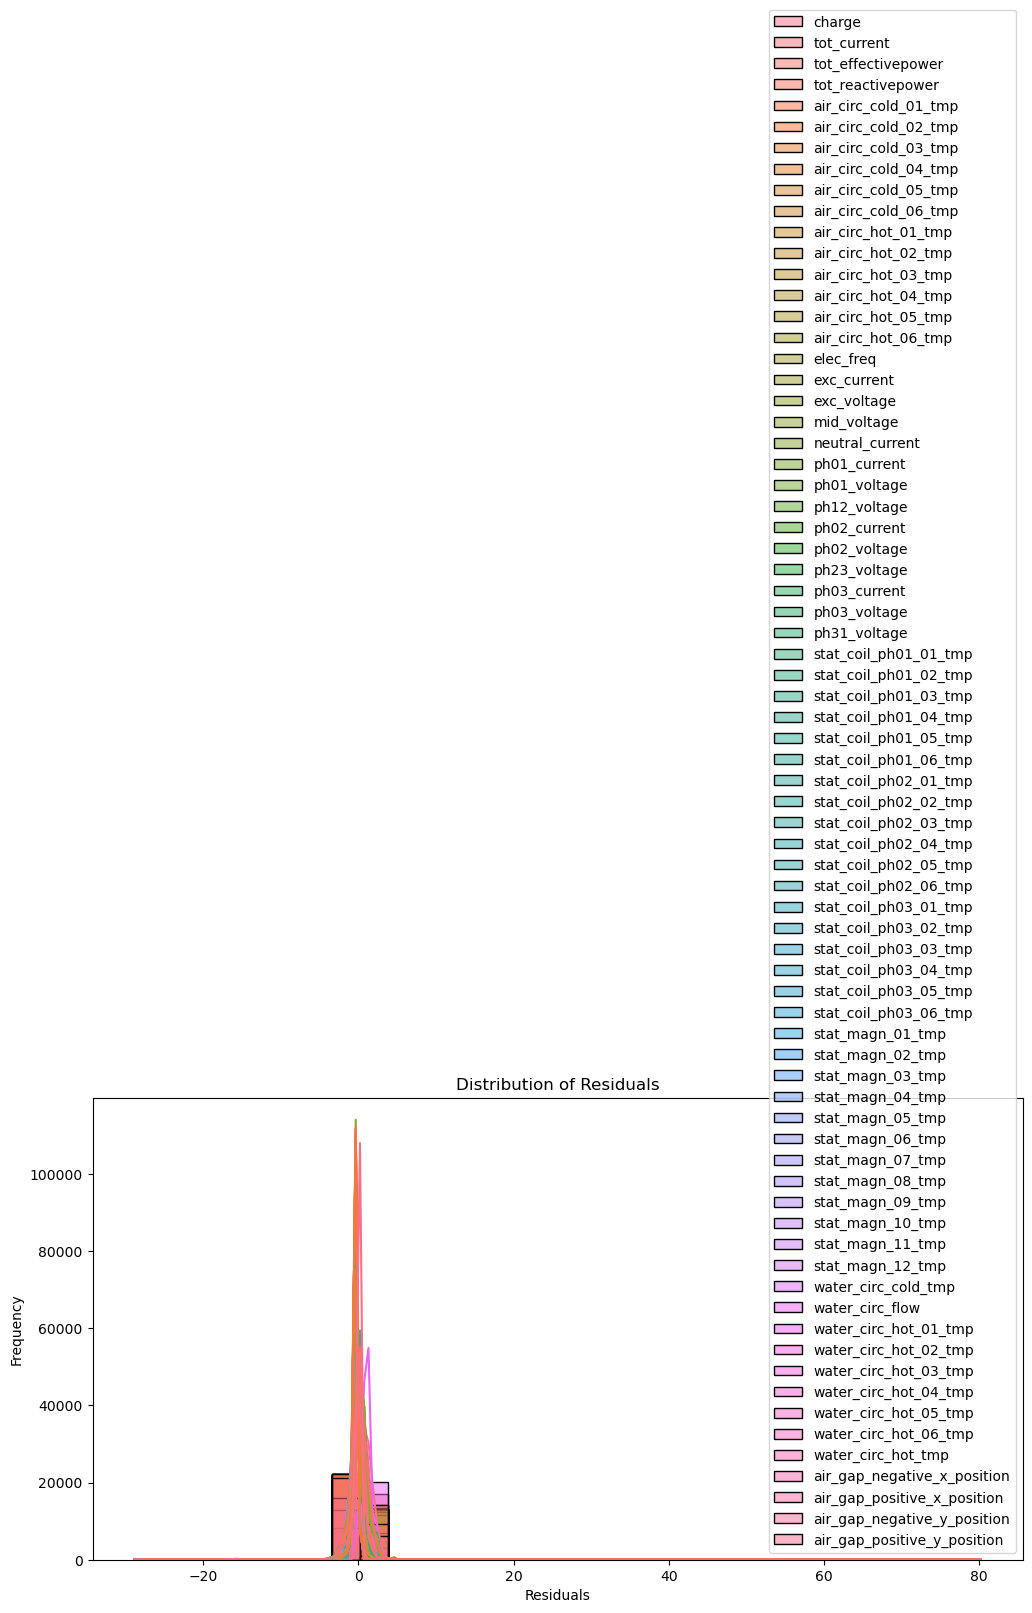

In [65]:
plt.figure(figsize=(12, 6))
sns.histplot(residuals_synthetic, kde=True, color='blue', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Accuracy: 0.854047479616199
F1-score: 0.9212789737110647


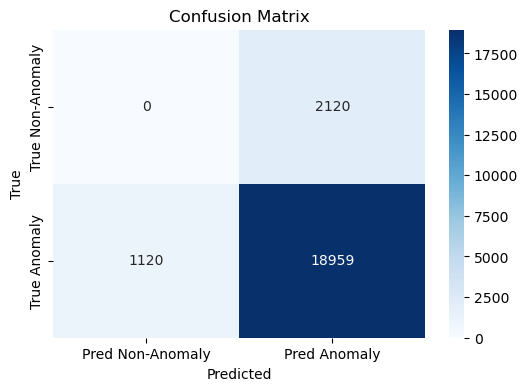

In [66]:
# Compute Accuracy and F1-score
acc = accuracy_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
print("Accuracy:", acc)
print("F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(true_anomalies, predicted_anomalies)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Non-Anomaly', 'Pred Anomaly'], 
            yticklabels=['True Non-Anomaly', 'True Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

AUC: 0.4239107412513027


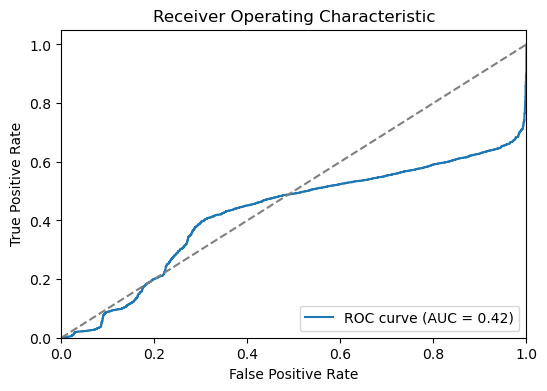

In [67]:
# ROC Curve and AUC
# Use the continuous residual norm as the "score" for ROC
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_synthetic_norm)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

# Plot the ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0,1],[0,1],'--', color='gray')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [68]:
# # Create a SHAP explainer for the Random Forest model
# explainer = shap.Explainer(final_model, X)

# # Compute SHAP values
# shap_values = explainer(X)

# # Summary plot to visualize the impact of each feature
# shap.summary_plot(shap_values, X)

# # Force plot for a single prediction (e.g., first instance)
# shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

In [69]:
X_sample = train.sample(n=100, random_state=42)  # Use only 100 samples

In [70]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_sample)

IndexError: index 68 is out of bounds for axis 1 with size 21

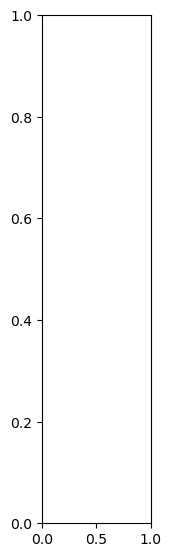

In [71]:
# Summary plot to visualize the impact of each feature
shap.summary_plot(shap_values, X_sample)

# Force plot for a single prediction (e.g., first instance)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_sample.iloc[0, :])